**BUFN 745 - Group Project (Section 0501 #8)** 

**Professor Alex He**
****
Submitted by:

Shifei Li

Mahesh Kumar

Mitchell Rosenthal

Mingjun Yu

Gilbert Lau


---



In [ ]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.linear_model import LassoCV, Lasso
import matplotlib

# Loading the Data

In [ ]:
data = pd.read_excel('https://drive.google.com/uc?export=download&id=1wKW8oXTze7Y23o8jSIPK813kgYEEpBPt')
data.head()

,gvkey,year,conm,ratingage,lrating,rt5,pic_bar,pic_a,pic_b,pic_c,pic_d,oits_bar,ltda_bar,tdta_bar,psize,error,beta,divpayer,mb,rd,reta,capexta,cbta,tang
0,3153,1985,COEUR D'ALENE MINES CORP,0,B+,4,18.268220,5.000000,5.0,8.268221,0.0,0.031972,0.142619,0.197369,4,0.021440,0.458946,0,1.685585,0.000000,0.142639,0.384187,0.127986,0.722496
1,6346,1985,CKE RESTAURANTS INC,0,BB,6,3.501001,3.501001,0.0,0.000000,0.0,0.106128,0.413169,0.473245,5,0.020131,0.895912,0,1.208645,0.000000,0.292416,0.155160,0.146204,0.608344
2,2078,1985,BASIX CORP,0,BB-,5,3.487855,3.487855,0.0,0.000000,0.0,0.304621,0.363550,0.421538,4,0.026428,1.755081,1,1.246256,0.000000,0.101246,0.289496,0.026975,0.497793
3,6541,1985,LA QUINTA INNS INC,0,B+,4,2.289249,2.289249,0.0,0.000000,0.0,0.406441,0.589561,0.608393,7,0.017331,0.730992,0,1.142472,0.000000,0.118531,0.170473,0.053176,0.864220
4,9842,1985,SOUTHEASTERN PUBLIC SVC CO,0,B-,2,2.022036,2.022036,0.0,0.000000,0.0,0.090152,0.322230,0.422658,4,0.021509,0.453236,0,0.898493,0.002579,0.036415,0.085104,0.118225,0.433218


In [ ]:
data.describe()

,gvkey,year,ratingage,rt5,pic_bar,pic_a,pic_b,pic_c,pic_d,oits_bar,ltda_bar,tdta_bar,psize,error,beta,divpayer,mb,rd,reta,capexta,cbta,tang
count,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000
mean,22891.569324,1997.238813,6.853447,8.161239,8.112219,3.740859,1.303936,1.060503,2.006922,0.018332,0.305754,0.351326,11.926399,0.023788,0.891417,0.606643,1.589236,0.015530,0.110945,0.070790,0.079193,0.401536
std,36981.428011,6.409798,5.899068,3.750508,13.856552,1.437465,1.960946,2.810354,10.422402,6.062161,0.192129,0.196118,5.788381,0.015398,0.525922,0.488505,1.043178,0.037704,0.452144,0.065693,0.107580,0.243636
min,1004.000000,1985.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-667.937500,0.000000,0.000000,1.000000,0.002655,-2.938716,0.000000,0.405978,0.000000,-16.861860,-0.014781,-0.009627,0.000000
25%,5354.000000,1992.000000,2.000000,5.000000,2.684611,2.684611,0.000000,0.000000,0.000000,0.092753,0.182025,0.227177,7.000000,0.014586,0.528663,0.000000,1.061705,0.000000,0.021068,0.031453,0.013450,0.196792
50%,9411.000000,1998.000000,5.000000,8.000000,4.266295,4.266295,0.000000,0.000000,0.000000,0.148824,0.278201,0.325425,13.000000,0.019981,0.837286,1.000000,1.296137,0.000000,0.147599,0.054055,0.038953,0.361254
75%,20783.000000,2003.000000,11.000000,11.000000,7.409087,5.000000,2.409087,0.000000,0.000000,0.239677,0.387545,0.434912,17.000000,0.028485,1.179868,1.000000,1.750013,0.014105,0.299910,0.088021,0.101397,0.600592
max,266163.000000,2007.000000,22.000000,17.000000,100.000000,5.000000,5.000000,10.000000,80.000000,0.941454,6.145140,6.177747,20.000000,0.821159,5.053000,1.000000,31.338770,2.051975,1.620717,1.472990,0.954193,0.966217


In [ ]:
data.isnull().sum()

gvkey        0
year         0
conm         0
ratingage    0
lrating      0
rt5          0
pic_bar      0
pic_a        0
pic_b        0
pic_c        0
pic_d        0
oits_bar     0
ltda_bar     0
tdta_bar     0
psize        0
error        0
beta         0
divpayer     0
mb           0
rd           0
reta         0
capexta      0
cbta         0
tang         0
dtype: int64

## Data Manipulation - Winsorize

In [ ]:
def winsor(series):
    col=series.copy(deep=True)
    
    q99 = col.quantile(.99)
    q01 = col.quantile(.01)

    col.loc[col > q99] = q99
    col.loc[col < q01] = q01
    
    return col

In [ ]:
#Winsorizing below and above 0.01/0.99 percentiles to eliminate the effect of outliers
targets = data.drop(['gvkey','year','conm','lrating','rt5'],axis=1)
targets.describe(percentiles=[.01,.05,.1,.25,.5,.75,.90,.95,.99])
dataw = [i for i in targets] # add "_w" suffixes for each string in targets (python iterator)
dataw = targets.apply(winsor)
dataw.describe()

,ratingage,pic_bar,pic_a,pic_b,pic_c,pic_d,oits_bar,ltda_bar,tdta_bar,psize,error,beta,divpayer,mb,rd,reta,capexta,cbta,tang
count,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000,23152.000000
mean,6.853447,8.112219,3.740859,1.303936,1.060503,2.006922,0.172946,0.303172,0.348618,11.926399,0.023555,0.890614,0.606643,1.562579,0.014890,0.122920,0.069649,0.077799,0.401423
std,5.899068,13.856552,1.437465,1.960946,2.810354,10.422402,0.145527,0.176469,0.178847,5.788381,0.013139,0.505984,0.488505,0.818430,0.031532,0.322813,0.058282,0.099994,0.243098
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.465959,0.011124,0.029108,1.000000,0.007466,-0.078419,0.000000,0.748188,0.000000,-1.440356,0.004767,0.000223,0.020489
25%,2.000000,2.684611,2.684611,0.000000,0.000000,0.000000,0.092753,0.182025,0.227177,7.000000,0.014586,0.528663,0.000000,1.061705,0.000000,0.021068,0.031453,0.013450,0.196792
50%,5.000000,4.266295,4.266295,0.000000,0.000000,0.000000,0.148824,0.278201,0.325425,13.000000,0.019981,0.837286,1.000000,1.296137,0.000000,0.147599,0.054055,0.038953,0.361254
75%,11.000000,7.409087,5.000000,2.409087,0.000000,0.000000,0.239677,0.387545,0.434912,17.000000,0.028485,1.179868,1.000000,1.750013,0.014105,0.299910,0.088021,0.101397,0.600592
max,22.000000,100.000000,5.000000,5.000000,10.000000,80.000000,0.636416,0.948006,0.989180,20.000000,0.077882,2.460366,1.000000,5.580465,0.165235,0.762398,0.328822,0.533365,0.901853


##Exploratory Data Analysis for feature selection

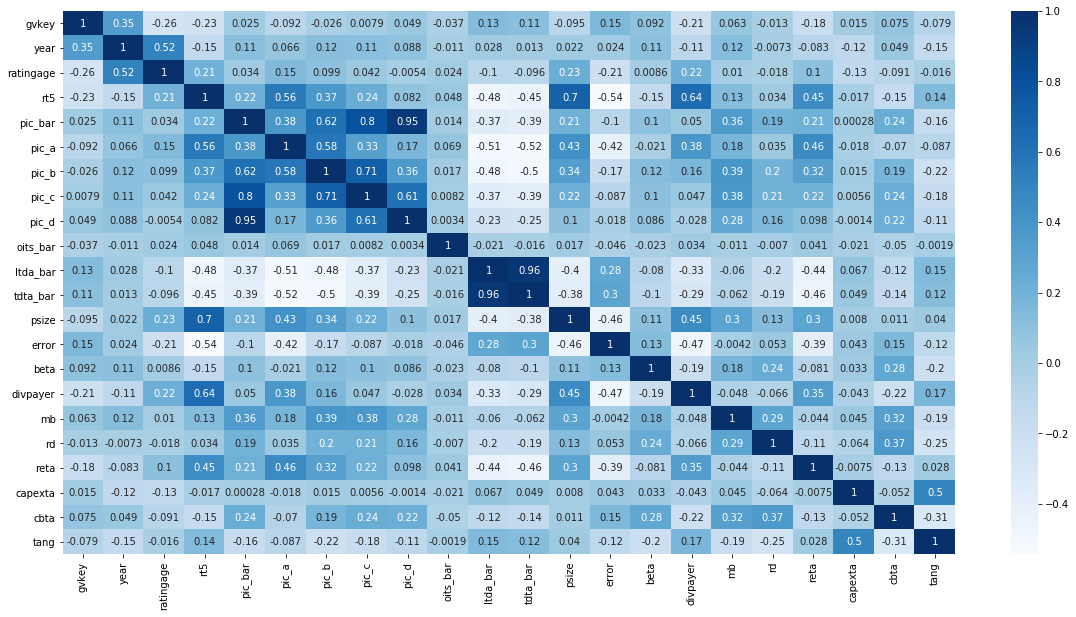

In [ ]:
#Visualization of correlation matrix using seaborn
import seaborn as sns
data_man = pd.DataFrame(data, columns = data.columns)
plt.figure(figsize=(20,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [ ]:
#Identifying highly correlated features
cor_target = abs(cor["rt5"])
relevant_features = cor_target[cor_target>0.5]#Threshold of highly relevant = 0.5
print(relevant_features.sort_values(ascending=False).index[1:])#Column names in descending order

Index(['psize', 'divpayer', 'pic_a', 'error'], dtype='object')


In [ ]:
#Dropping variable 'pic_bar' since it is redundant and has a strong correlation with other variables of the dataset
dataw=dataw.drop(["pic_bar"],axis=1)

#Lasso

In [ ]:
#Input for Lasso
y = data['rt5']
x = dataw

In [ ]:
#Lasso regression is used to create a subset of variables from the dataset
reg = LassoCV()
reg.fit(x,y)
coef = pd.Series(reg.coef_, index = x.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 12 variables and eliminated the other 6 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

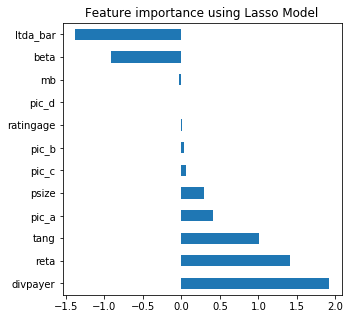

In [ ]:
#Plotting coefficients of feature importance obtained from Lasso
imp_coef = coef[abs(coef!=0)].sort_values(ascending=False)
plt.rcParams['figure.figsize'] = (5, 5)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [ ]:
print(coef[abs(coef!=0)].sort_values(ascending=False).index)#printing the column names with high feature importance

Index(['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b',
       'ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar'],
      dtype='object')


## Splitting Train & Test

In [ ]:
from sklearn.model_selection import train_test_split
x_new = dataw[['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b','ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar']]#slicing data as per exploratory data analysis
x_train, x_test, y_train, y_test = train_test_split(x_new, y , test_size = 0.33, random_state = 42)#using train_test_split function

# MARS

In [ ]:
!pip install sklearn-contrib-py-earth
from pyearth import Earth
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
model = Earth()#pyearth MARS
model.fit(x_train, y_train)
pred =model.predict(x_test)
#Print the model
print(model.trace())#tracing the model
print(model.summary())#printing coefficients

/usr/local/lib/python3.6/dist-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
------------------------------------------------------------------
iter  parent  var  knot   mse        terms  gcv     rsq    grsq   
------------------------------------------------------------------
0     -       -    -      13.983034  1      13.985  0.000  0.000  
1     0       4    -1     7.243997   2      7.247   0.482  0.482  
2     0       0    -1     5.442387   3      5.447   0.611  0.611  
3     0       1    13951  4.591143   5      4.598   0.672  0.671  
4     0       10   6512   4.323222   7      4.332   0.691  0.690  
5     0       3    11537  4.133462   9      4.145   0.704  0.704  
6     0       11   10952  4.014310   11     4.028   0.713  0.712  
7     0       2    13557  3.877595   13     3.893   0.723  0.722  
8     0       9    9721   3.859964   15     3.878   0.724  0.723  
9     0       9    6702   3.837659   17     3.858   0.726  0.724  
10    0       11   13099  3.824668   19     3.847   0.726  0.725  
-------------------------------------------------

/usr/local/lib/python3.6/dist-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


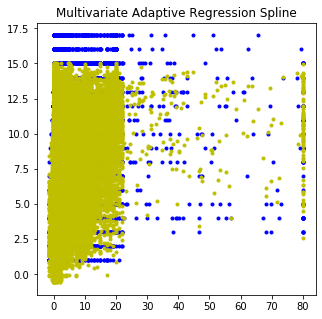

In [ ]:
#Plot the model
y_hat =model.predict(x_test)#predicted values
plt.figure()
plt.plot(x_test,y_test,'b.')
plt.plot(x_test,y_hat,'y.')
plt.title('Multivariate Adaptive Regression Spline')#predicted vs test - measures accuracy
plt.show()

In [ ]:
#Calculating RMSE values for MARS
rms5 = sqrt(mean_squared_error(y_test, pred))
print(rms5)

1.9419734472233598


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=16, max_depth=13)
rf.fit(x_train, y_train)

rf.predict(x_test)
print(r2_score(y_test, rf.predict(x_test)))


0.8190364768010728


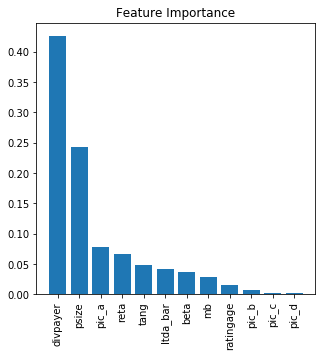

In [ ]:
importances=rf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [x_train.columns[i] for i in indices]
plt.figure()
plt.title("Feature Importance")#graphical representation of feature importance
plt.bar(range(x_train.shape[1]), importances[indices])
plt.xticks(range(x_train.shape[1]), names, rotation =90)
plt.show()

In [ ]:
#List of variables selected
exog_var = ['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b','ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar']

## Multinomial Logit

In [ ]:
import statsmodels.discrete.discrete_model as discrete
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
from sklearn.linear_model import LogisticRegression
mlogit_mod = LogisticRegression(random_state=42, multi_class='multinomial', penalty='none', solver='newton-cg').fit(x_train, y_train)#Multinomial Logit
print(mlogit_mod.coef_)
print(mlogit_mod.intercept_)

[[-2.66085900e+00 -4.22163763e+00 -1.72416800e+00 -1.57482456e+00
  -6.46735913e-01 -1.41023893e-01  6.15424286e-01 -3.24430053e-02
   8.94536006e-03  2.95633599e-01  1.71490708e+00  6.05811230e+00]
 [-2.89121049e+00 -3.78160539e+00 -2.31457043e+00 -1.38324535e+00
  -5.64143397e-01 -8.17491054e-03  4.49162208e-01 -2.33387724e-02
   8.28497125e-03  3.97990700e-01  2.14990187e+00  5.77191591e+00]
 [-2.78129499e+00 -3.56709574e+00 -2.48352111e+00 -1.01665687e+00
  -5.04426755e-01 -4.34800053e-03  2.95679260e-01 -3.47229626e-02
   1.59599354e-02  2.52837215e-01  1.82357877e+00  6.38320035e+00]
 [-2.28824208e+00 -3.10472503e+00 -2.44341439e+00 -5.27863127e-01
  -4.55031120e-01  7.86325633e-02 -8.64931588e-03 -4.02168301e-02
   3.16309885e-03  2.40051494e-01  1.71028663e+00  6.06276632e+00]
 [-2.08391258e+00 -2.49559433e+00 -2.15142169e+00 -2.75246301e-01
  -3.41703870e-01  3.90816134e-02 -6.51967283e-02 -1.46399616e-02
   9.89984543e-03  6.68781061e-02  1.48629721e+00  6.27519721e+00]
 [-1.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [ ]:
mlogit_TrainPreds = mlogit_mod.predict(x_train)#in sample
mlogit_TestPreds = mlogit_mod.predict(x_test)#out of sample

mlogit_RMSEtrain = sqrt(mean_squared_error(y_train,mlogit_TrainPreds))
mlogit_RMSEtest = sqrt(mean_squared_error(y_test,mlogit_TestPreds))

print('mlogit train RMSE is ' + str(mlogit_RMSEtrain))
print('mlogit test RMSE is ' + str(mlogit_RMSEtest))

mlogit train RMSE is 2.082342080385926
mlogit test RMSE is 2.0857485019158806


## Ordered Logit

In [ ]:
!pip install mord
import mord as m

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import probit
from statsmodels.formula.api import logit
from sklearn.utils import resample # for bootstrap
import scipy.stats # for confidence interval
c = m.LogisticAT()#Ordered Logit
reg = c.fit(x_train,y_train)

O_logit_TrainPreds = reg.predict(x_train)#in sample
O_mlogit_TestPreds = reg.predict(x_test)#out of sample

O_logit_RMSEtrain = sqrt(mean_squared_error(y_train,O_logit_TrainPreds))
O_logit_RMSEtest = sqrt(mean_squared_error(y_test,O_mlogit_TestPreds))

print('Ologit train RMSE is ' + str(O_logit_RMSEtrain))
print('Ologit test RMSE is ' + str(O_logit_RMSEtest))

Ologit train RMSE is 1.9741740454243726
Ologit test RMSE is 1.9536575720045466


# Part 2

In [ ]:
#Working with the entire dataset

data1985 = data[data['year']==1985]
#data1985x = data[data['year']==1985]
data1985y = data1985['rt5']

def winsor(series):
    col=series.copy(deep=True)
    
    q99 = col.quantile(.99)
    q01 = col.quantile(.01)

    col.loc[col > q99] = q99
    col.loc[col < q01] = q01
    
    return col

targets = data1985.drop(['gvkey','year','conm','lrating','rt5'],axis=1)
targets.describe(percentiles=[.01,.05,.1,.25,.5,.75,.90,.95,.99])
dataw = [i for i in targets] # add "_w" suffixes for each string in targets (python iterator)
dataw = targets.apply(winsor)
dataw.describe()

x_new_1985=dataw[['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b','ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar']]


### Using model for 1985


Mean Absolute Error of LogisticAT 1.591743119266055
[1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007]
1986: 1985 model is 0.15442092154420806 above actual
1987: 1985 model is 0.1236363636363631 above actual
1988: 1985 model is -0.01668806161745806 above actual
1989: 1985 model is -0.08115543328748309 above actual
1990: 1985 model is -0.04831625183016186 above actual
1991: 1985 model is -0.2463768115942031 above actual
1992: 1985 model is -0.3656618610747042 above actual
1993: 1985 model is -0.320284697508896 above actual
1994: 1985 model is -0.19101123595505598 above actual
1995: 1985 model is -0.09717868338558056 above actual
1996: 1985 model is -0.018518518518519045 above actual
1997: 1985 model is -0.021150592216581998 above actual
1998: 1985 model is -0.146531566640685 above actual
1999: 1985 model is -0.011923688394277043 above actual
2000: 1985 model is -0.031695721077654504 above actual
2001: 1985

ImportError: ignored

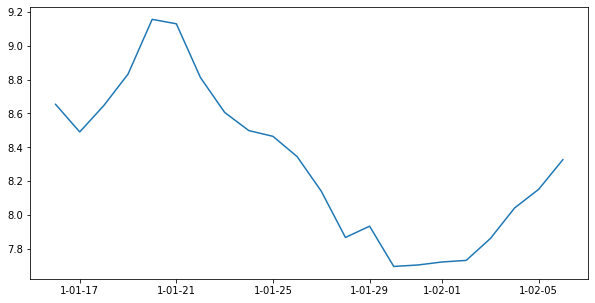

In [ ]:
# Part 2 Problem 1

ordered_logit_exogs = ['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b','ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar']
# estimate model for 1985

# Train/test split
from sklearn.model_selection import train_test_split
trainx, validx, trainy, validy = train_test_split(x_new_1985, data1985y, test_size=0.3, random_state = 1)

# 1985 ordered logit
!pip install mord
import mord as m
from sklearn import metrics
from sklearn.metrics import mean_squared_error

ordered_logit_exogs = ['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b','ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar']
c = m.LogisticAT()
reg_1985 = c.fit(trainx, trainy)
print('Mean Absolute Error of LogisticAT %s' %
      metrics.mean_absolute_error(reg_1985.predict(validx),validy))


ListOfYears = data['year'].unique().tolist()
ListOfYears.remove(1985)
print(ListOfYears)
column_names = ["year", "pred_mean", "actual_mean"]
dfpreds = pd.DataFrame(columns = column_names)
YearlyPreds = []
YearlyActuals = []

for year in ListOfYears:
  dfnew = data[data['year']==year]
  dfnewx = dfnew[ordered_logit_exogs]
  dfnewy = dfnew['rt5']
  yprednew = reg_1985.predict(dfnewx)
  ymeannew = yprednew.mean()
  YearlyPreds.append(ymeannew)
  YearlyActuals.append(dfnewy.mean())

  PredVsActual = ymeannew - dfnewy.mean()
  print(str(year) + ': 1985 model is ' + str(PredVsActual) + ' above actual')
  pass

dfpreds['year'] = ListOfYears
dfpreds['year'] = pd.to_datetime(dfpreds['year'].astype(str), format="%Y")
dfpreds['pred_mean'] = YearlyPreds
dfpreds['actual_mean'] = YearlyActuals

dfpreds.plot(x='year', y=['pred_mean', 'actual_mean'], figsize=(10,5), grid=False, title='1985 Model Predictions')

#total_year[-15:].plot(x='year', y=['action', 'comedy'], figsize=(10,5), grid=True)


# Ratings were looser in 1986, 1987, 1988, 1995 (slightly), 1996, 1997, 1999 - 2007. 
# Ratings were looser in year  1988 to 2001
# Overall, ratings became more loose from 1985 to 2007.
# Note that the ratings became increasingly loose from 2001 to 2007, with the average underestimation error rising from 0.095 to 1.23. 
# This is consistent with the narrative that bond rating agencies like S&P became far less strict in yrs leading to 08.


### Separate the sample into speculative grade and investment-grade

In [ ]:
# Part 2 Problem 2

# BBB- and above means rt5 >= 10. BB+ and below means rt5 <= 9.

# Separating samples
investgrade = data[data['rt5'] >= 10]
specgrade = data[data['rt5'] <= 9]

print('Investment grade: ')

temp1=pd.DataFrame()
temp2=[]
for year in ListOfYears:
  dfnew = investgrade[investgrade['year']==year]
  dfnewx = dfnew[x_new.columns]
  dfnewy = dfnew['rt5']
  yprednew = reg_1985.predict(dfnewx)
  ymeannew = yprednew.mean()
  PredVsActual = ymeannew - dfnewy.mean()
  temp1['p1']=PredVsActual
  temp1['y1']=year
  print('Invest grade ' + str(year) + ': 1985 model is ' + str(PredVsActual) + ' above actual')
  pass

for year in ListOfYears:
  dfnew = specgrade[specgrade['year']==year]
  dfnewx = dfnew[x_new.columns]
  dfnewy = dfnew['rt5']
  yprednew = reg_1985.predict(dfnewx)
  ymeannew = yprednew.mean()
  PredVsActual = ymeannew - dfnewy.mean()
  print('Spec grade ' + str(year) + ': 1985 model is ' + str(PredVsActual) + ' above actual')
  pass

# The pattern is different for investment grade and speculative grade.
# Speculative grade bond ratings became far less strict than those for ivnestment grade.
# The rating errors for speculative bonds increased far faster than those for investment grade.

### Newly rated bonds

In [ ]:
# Part 2 Problem 3

# Checking pattern for newly rated bonds, where ratingage = 0. 

newlyrated = data[data['ratingage'] == 0]

for year in ListOfYears:
  dfnew = newlyrated[newlyrated['year']==year]
  dfnewx = dfnew[x_new.columns]
  dfnewy = dfnew['rt5']
  yprednew = reg_1985.predict(dfnewx)
  ymeannew = yprednew.mean()
  PredVsActual = ymeannew - dfnewy.mean()
  print(str(year) + ': 1985 model is ' + str(PredVsActual) + ' above actual')
  pass

# The pattern is also present for newly rated bonds, but is less severe. 

### Using model for 1990

In [ ]:
# Part 2 Problem 4

# Trying a different model. Use year 1990.

# filter for year just for 1990
data1990 = data[data['year']==1990]
data1990y = data1990['rt5']
def winsor(series):
    col=series.copy(deep=True)
    
    q99 = col.quantile(.99)
    q01 = col.quantile(.01)

    col.loc[col > q99] = q99
    col.loc[col < q01] = q01
    
    return col

targets = data1990.drop(['gvkey','year','conm','lrating','rt5'],axis=1)
targets.describe(percentiles=[.01,.05,.1,.25,.5,.75,.90,.95,.99])
dataw = [i for i in targets] # add "_w" suffixes for each string in targets (python iterator)
dataw = targets.apply(winsor)
dataw.describe()

x_new=dataw[['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b','ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar']]


# Train/test split
from sklearn.model_selection import train_test_split
trainx, validx, trainy, validy = train_test_split(x_new, data1990y, test_size=0.3, random_state = 42)

# 1990 ordered logit
#!pip install mord
import mord as m
from sklearn import metrics
from sklearn.metrics import mean_squared_error

c = m.LogisticAT()
reg_1990 = c.fit(trainx, trainy)

print('Mean Absolute Error of LogisticAT %s' %
      metrics.mean_absolute_error(reg_1990.predict(validx),validy))


ListOfYears = data['year'].unique().tolist()
ListOfYears.remove(1985)
ListOfYears.remove(1986)
ListOfYears.remove(1987)
ListOfYears.remove(1988)
ListOfYears.remove(1989)
ListOfYears.remove(1990)

print(ListOfYears)

for year in ListOfYears:
  dfnew = data[data['year']==year]
  dfnewx = dfnew[x_new.columns]
  dfnewy = dfnew['rt5']
  yprednew = reg_1990.predict(dfnewx)
  ymeannew = yprednew.mean()
  PredVsActual = ymeannew - dfnewy.mean()
  print(str(year) + ': 1990 model is ' + str(PredVsActual) + ' above actual')
  pass


# Part 3

In [ ]:
data1 = pd.read_csv('https://drive.google.com/uc?export=download&id=1aAPlUBH-phTfCPrihjp13LV4gDOuvq3f')
#ratings = data1.drop(['Year ','Average_all_ratings'],axis=1)
#data1.head(20)

data1years = data1['Year '].unique().tolist()
ListOfYears = data1['Year '].unique().tolist()
ListOfYears.remove(1981)
ListOfYears.remove(1982)
ListOfYears.remove(1983)
ListOfYears.remove(1984)
ListOfYears.remove(1985)

data2 = data1

# Delete these row indexes from dataFrame
data2.drop(data2[ data2['Year '] <= 1985 ].index, inplace=True)
data2.drop(data2[ data2['Year '] == 2008 ].index, inplace=True)

# filter for year just for 1985

data1985 = data[data['year']==1985]
data1985x = data1985.drop(['gvkey', 'year','conm','rt5','lrating'], axis=1)
data1985y = data1985[['rt5']]

# Train/test split
from sklearn.model_selection import train_test_split
trainx, validx, trainy, validy = train_test_split(data1985x, data1985y, test_size=0.3, random_state = 1)

# 1985 ordered logit
#!pip install mord
import mord as m
from sklearn import metrics
from sklearn.metrics import mean_squared_error

ordered_logit_exogs = ['divpayer', 'reta', 'tang', 'pic_a', 'psize', 'pic_c', 'pic_b','ratingage', 'pic_d', 'mb', 'beta', 'ltda_bar']
c = m.LogisticAT()
reg_1985 = c.fit(trainx[ordered_logit_exogs], trainy['rt5'])
print('Mean Absolute Error of LogisticAT %s' %
      metrics.mean_absolute_error(reg_1985.predict(validx[ordered_logit_exogs]),validy['rt5']))

ListOfYears = data['year'].unique().tolist()
ListOfYears.remove(1985)
print(ListOfYears)
PredVsActual4 = []

for year in ListOfYears:
  dfnew = data[data['year']==year]
  dfnewx = dfnew[ordered_logit_exogs]
  dfnewy = dfnew['rt5']
  yprednew = reg_1985.predict(dfnewx)
  ymeannew = yprednew.mean()
  PredVsActual = ymeannew - dfnewy.mean()
  PredVsActual4.append(PredVsActual)
  print(str(year) + ': 1985 model is ' + str(PredVsActual) + ' above actual')
  pass

data2['PredVsActual'] = PredVsActual4
data2



In [ ]:
formula = "Average_all_ratings~ PredVsActual"
model = smf.ols(formula=formula,data=data1).fit()
print(model.summary())

Ho: Rating agency’s standards does not affect the default rate 

HA: Rating agency’s standards has significant effect on the default rate

With a p-value < 0.05 , we can reject the NULL Hypothesis with a 95% level of confidence

A negative coefficient suggests that with a unit rise in PredictedvsActual
(i.e.) Predicted being higher than actual, the default rate will be lower
